In [91]:
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
import os
import matplotlib.pyplot as plt
from owslib.wms import WebMapService
from IPython.display import display
import numpy as np
from matplotlib.colors import ListedColormap

In [92]:
class DataProcessor:
    def __init__(self, file_path, wms_url, layer_name, bbox, output_dir):
        self.file_path = file_path
        self.wms_url = wms_url
        self.layer_name = layer_name
        self.bbox = bbox
        self.output_dir = output_dir

    def load_geotiff(self):
        """Load the GeoTIFF data from a file."""
        display(f"Loading data from {self.file_path}")
        try:
            return rasterio.open(self.file_path)
        except Exception as e:
            display(f"Failed to load data from {self.file_path}: {e}")
            raise

    def download_data(self):
        """
        Download data from a WMS.
        """
        display(f"Downloading data from {self.wms_url}")

        try:
            # Connect to the WMS
            wms = WebMapService(self.wms_url)

            # Get the data as a GeoTIFF
            img = wms.getmap(
                layers=[self.layer_name],
                styles=['default'],
                srs='EPSG:3857',
                bbox=self.bbox,
                size=(256, 256),
                format='image/geotiff',
                transparent=True
            )

            # Save the data to a file
            with open(self.file_path, 'wb') as f:
                f.write(img.read())

            display(f"Data downloaded to {self.file_path}")
        except Exception as e:
            display(f"Failed to download data from {self.wms_url}: {e}")
            raise

    def reclassify(self, dataset):
        """Reclassify the raster data into broader land use categories."""
        display("Reclassifying data")

        # Define your reclassification rules here
        reclassification_rules = {
            1: [211, 212, 213, 221, 222, 223, 241, 242, 243, 244],  # agriculture
            2: [111, 112],  # urban
            3: [121, 122, 123, 124, 131, 132, 133],  # industry
            4: [523],  # water_bodies
            5: [311, 312, 313],  # nature_forest
            6: [231]  # meadow
        }

        # Create a dictionary to map integers to category names
        category_names = {
            1: 'agriculture',
            2: 'urban',
            3: 'industry',
            4: 'water_bodies',
            5: 'nature_forest',
            6: 'meadow'
        }

        # Read the raster data into a numpy array
        data = dataset.read(1)

        # Create an empty array for the reclassified data
        reclassified = np.empty(data.shape, dtype=np.int8)

        # Apply the reclassification rules
        for category, codes in reclassification_rules.items():
            for code in codes:
                reclassified[data == code] = category

        return reclassified, category_names

    def export_data(self, reclassified, category, category_names):
        """Export the data of each land use type as a separate tiff file."""
        output_path = os.path.join(self.output_dir, f"{category_names[category]}.tif")
        display(f"Exporting data to {output_path}")

        # Assuming 'values' is a 2D array containing your data
        values = reclassified == category

        # Assuming 'transform' is a rasterio.transform object
        transform = from_origin(0, 0, 1, 1)  # Replace with your actual transform

        # Assuming 'crs' is a rasterio.crs.CRS object representing the coordinate reference system
        crs = rasterio.crs.CRS.from_string('EPSG:3857')  # Replace with your actual CRS

        with rasterio.open(output_path, 'w', driver='GTiff', height=values.shape[0], 
                        width=values.shape[1], count=1, dtype='uint8',
                        crs=crs, transform=transform) as dst:
            dst.write(values.astype(rasterio.uint8), 1)

    def visualize(self, reclassified, category_names):
        """Visualize the reclassified data."""
        # legenda color map
        color_map = ListedColormap([
            'red',        # agriculture
            'blue',       # urban
            'darkgrey',   # industry
            'lightblue',  # water_bodies
            'green',      # nature_forest
            'yellow',     # meadow
            'white'       # other
        ])

        fig, ax = plt.subplots(1, 1)
        for category in np.unique(reclassified):
            if category > 0:
                ax.imshow((reclassified == category), cmap=color_map, alpha=0.5)
        plt.show()

    def process(self):
        # Check if output directory exists, if not, create it
        os.makedirs(self.output_dir, exist_ok=True)

        self.download_data()
        dataset = self.load_geotiff()
        reclassified, category_names = self.reclassify(dataset)
        for category in np.unique(reclassified):
            if category in category_names:
                self.export_data(reclassified, category, category_names)
        self.visualize(reclassified, category_names)

'Downloading data from https://image.discomap.eea.europa.eu/arcgis/services/Corine/CLC2018_WM/MapServer/WMSServer?service=WMS&request=GetCapabilities&version=1.3.0'

'Data downloaded to corine_data_landcover.tif'

'Loading data from corine_data_landcover.tif'

'Reclassifying data'

'Exporting data to corine_reclassify_GTiff/agriculture.tif'

'Exporting data to corine_reclassify_GTiff/urban.tif'

'Exporting data to corine_reclassify_GTiff/industry.tif'

'Exporting data to corine_reclassify_GTiff/water_bodies.tif'

'Exporting data to corine_reclassify_GTiff/nature_forest.tif'

'Exporting data to corine_reclassify_GTiff/meadow.tif'

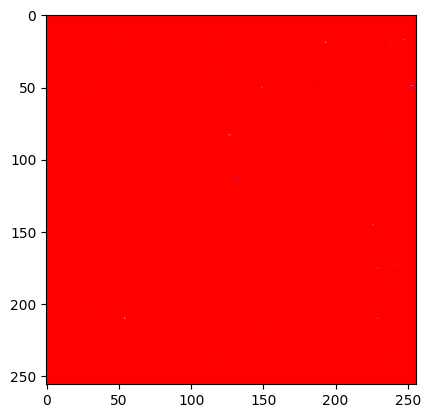

In [93]:
if __name__ == "__main__":
    processor = DataProcessor(
        file_path='corine_data_landcover.tif',
        wms_url='https://image.discomap.eea.europa.eu/arcgis/services/Corine/CLC2018_WM/MapServer/WMSServer?service=WMS&request=GetCapabilities&version=1.3.0',
        layer_name='0',
        bbox=(3.31497114423, 50.803721015, 7.09205325687, 53.5104081412),
        output_dir='corine_reclassify_GTiff'
    )
    processor.process()